# CPPN System

A way to train a Compositional Pattern-Producing Network (CPPN) on user content.

Possible approach: convert SBCs to Structure, then extract the inner `_structure` array, polish it, train an AutoEncoder to learn the latent distribution of the data and then train a CPPN to output the original data from this.

In [1]:
from pcgsepy.structure import *
from pcgsepy.common.vecs import *
from pcgsepy.common.api_call import *
from pcgsepy.xml_conversion import *

import matplotlib.pyplot as plt
import numpy as np
from random import sample
import xml.etree.ElementTree as ET

### Convert `sbc`s to a `Structure`

In [47]:
N = 1

structures = []

files = sample([f for f in os.listdir('content') if f.endswith('sbc')],
               k=N)

In [48]:
for f in files:
    sbc_file = os.path.join('content', f)
    root = ET.parse(sbc_file).getroot()
    
    structures.append(convert_xml_to_structure(root_node=root,
                                               struct_dim=600))
    

### Polishing `_structure` representation

Convert the `Structure` to an array where each element is either 0 or the normalized index of the `BlockDefinitionId` in the list.

In [49]:
s = structures[0]

arr = np.zeros((s._structure.shape))
blocks = s.get_all_blocks()

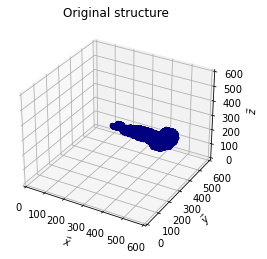

In [50]:
plot_structure(structure=s,
               title='Original structure',
               axis_limits=(600, 600, 600))

In [51]:
# compute min dims of structure
min_x, min_y, min_z = arr.shape[0], arr.shape[1], arr.shape[2]
max_x, max_y, max_z = 0, 0, 0

for block in blocks:
    x, y, z = block.position.x, block.position.y, block.position.z
    x *= 2
    y *= 2
    z *= 2
    min_x = x if x < min_x else min_x
    min_y = y if y < min_y else min_y
    min_z = z if z < min_z else min_z
    max_x = x if x > max_x else max_x
    max_y = y if y > max_y else max_y
    max_z = z if z > max_z else max_z

print(f'Box in ({min_x}, {min_y}, {min_z}) to ({max_x}, {max_y}, {max_z})')

Box in (265.0, 235.0, 275.0) to (565.0, 365.0, 325.0)


In [52]:
ids = list(block_definitions.keys())

In [64]:
# put block id in arr
for block in blocks:
    b_id = ids.index(block.block_type)
    x, y, z = block.position.x, block.position.y, block.position.z
    x *= 2
    y *= 2
    z *= 2    
    
    arr[int(x - min_x), int(y - min_y), int(z - min_z)] = b_id / len(ids)

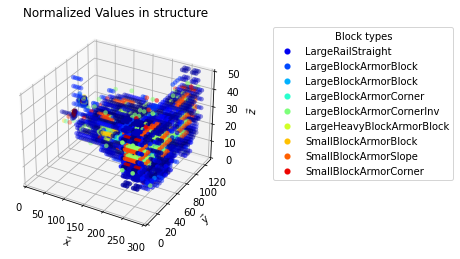

In [67]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

ax = plt.axes(projection='3d')
x, y, z = np.nonzero(arr)
cs = [arr[i, j, k] for i, j, k in zip(x, y, z)]

scatter = ax.scatter(x, y, z, c=cs, cmap='jet', linewidth=0.1)

legend = scatter.legend_elements()
for i, v in zip(range(len(legend[1])), np.unique(arr)):
    legend[1][i] = ids[int(v * len(ids))]
ax.legend(*legend, bbox_to_anchor=(1.2,1),
          loc="upper left", title="Block types")

ax.set_xlim3d(0, int(max_x - min_x))
ax.set_ylim3d(0, int(max_y - min_y))
ax.set_zlim3d(0, int(max_z - min_z))

ax.set_xlabel("$\\vec{x}$")
ax.set_ylabel("$\\vec{y}$")
ax.set_zlabel("$\\vec{z}$")

plt.title('Normalized Values in structure')

plt.show()